In [1]:
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
import cv2
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import glob
from matplotlib.image import imread
import time

In [2]:
test_images = [plt.imread(image) for image in glob.glob('test_images/*.jpg')]

## Camera Calibration
We start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here we are assuming the chessboard is fixed on the   (x, y) plane at z=0, such that the object points are the same for each calibration image. Thus, objp is just a replicated array of coordinates, and objpoints will be appended with a copy of it every time I successfully detect all chessboard corners in a test image. imgpoints will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.

We then used the output objpoints and imgpoints to compute the camera calibration and distortion coefficients using the cv2.calibrateCamera() function. I applied this distortion correction to the test image using the cv2.undistort() function 


In [3]:
def calibrate_camera():
    
    """
        Calibrate camera from the provided calibration images
    """
    nx = 9
    ny = 6
    images = glob.glob('camera_cal/calibration*.jpg')
    
    print("Starting Calibrating Camera")
    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Apply findChessboardCorners to the individual images
    for fname in images:    
        img = mpimg.imread(fname)
        image_shape = img.shape
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    # Camera calibration, given object points, image points, and the shape of the grayscale image
    if (len(objpoints) > 0):
        # Camera successfully calibrated.
        print("Camera successfully calibrated.")
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_shape[:2], None, None)
    else:
        # Unable to calibrate the camera.
        print("Unable to calibrate the camera.")
        ret, mtx, dist, rvecs, tvecs = (None, None, None, None, None)

    return mtx, dist

mtx, dist = calibrate_camera()
    
def undistort(image):
    """
        Remove the distortion of an image 
    """
    return cv2.undistort(image, mtx, dist, None, mtx)

Starting Calibrating Camera
Camera successfully calibrated.


## Showing Images

In [4]:
def show_images(images, cmap=None):
    """
      show list of images  
    """
    plt.figure(figsize=(40,40))    
    for i, image in enumerate(images):
        plt.subplot(math.ceil(len(images) / 2), 2, i+1)
        plt.imshow(image, cmap)
        plt.autoscale(tight=True)
    plt.show()
    
# show_images(test_images)

## Applying function to a list of images

In [5]:
def apply(fun, images):
    """
        apply function to list of images
    """
    return list(map(fun, images))

## Converting between image colors

In [6]:
def convert_to_hls(image):
    """
        Convert RGB image to HLS
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

def convert_to_gray(image):
    """
        Convert RGB image to grayscale
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def convert_to_rgp(image):
    """
        Convert RGB image to grayscale
    """
    return cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

gray_images = apply(convert_to_gray, test_images)
# show_images(gray_images, "gray")
hls_images = apply(convert_to_hls, test_images)
# show_images(hls_images)

## Extracting Yellow and White colors from image

In [7]:
def hls_color_threshold(image):
    """
        Extract yellow and white colors from image
    """
    # Convert the input image to HLS
    converted_image = convert_to_hls(image)
    
    # White color mask
    lower_threshold = np.uint8([0, 190, 0])
    upper_threshold = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(converted_image, lower_threshold, upper_threshold)
    
    # Yellow color mask
    lower_threshold = np.uint8([10, 0, 90])
    upper_threshold = np.uint8([50, 255, 255])
    yellow_mask = cv2.inRange(converted_image, lower_threshold, upper_threshold)
    
    # Combine white and yellow masks
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked_image = cv2.bitwise_and(image, image, mask = mask)
    
    return masked_image

hls_color_threshold_images = apply(hls_color_threshold, test_images)
# show_images(hls_color_threshold_images, "gray")

## Applying Thresholds

In [8]:
def apply_thresholds(image):
    """
        apply all the thresholds on image
    """
    hls = hls_color_threshold(image)
    gray = hls[:, :, 1]
    s_channel = hls[:, :, 2]
    
    sobel_binary = np.zeros(shape=gray.shape, dtype=bool)
    s_binary = sobel_binary
    combined_binary = s_binary.astype(np.float32)

    # Sobel Transform
    sobel_kernel=7 
    mag_thresh=(3, 255)
    s_thresh=(170, 255)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = 0 #cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    sobel_abs = np.abs(sobelx**2 + sobely**2)
    sobel_abs = np.uint8(255 * sobel_abs / np.max(sobel_abs))

    sobel_binary[(sobel_abs > mag_thresh[0]) & (sobel_abs <= mag_thresh[1])] = 1

    # Threshold color channel
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Combine the two binary thresholds

    combined_binary[(s_binary == 1) | (sobel_binary == 1)] = 1
    combined_binary = np.uint8(255 * combined_binary / np.max(combined_binary))
    
    return combined_binary

threshold_images = apply(apply_thresholds, test_images)
# show_images(threshold_images, "gray")

## Region of Interest Extraction

In [9]:
def extract_region_of_interest(image):
    x = int(image.shape[1])
    y = int(image.shape[0])
    shape = np.array([[0, y], [x, y], [int(0.55 * x), int(0.6 * y)], [int(0.45 * x), int(0.6 * y)]])

    # define a numpy array with the dimensions of image, but comprised of zeros
    mask = np.zeros_like(image)

    # Uses 3 channels or 1 channel for color depending on input image
    if len(image.shape) > 2:
        channel_count = image.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # creates a polygon with the mask color
    cv2.fillPoly(mask, np.int32([shape]), ignore_mask_color)

    # returns the image only where the mask pixels are not zero
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

roi_images = apply(extract_region_of_interest, threshold_images)
# show_images(roi_images, "gray")

## Perspective Transform

In [10]:
def warp(img):
    # Vertices extracted manually for performing a perspective transform
    bottom_left = [220,720]
    bottom_right = [1110, 720]
    top_left = [570, 470]
    top_right = [722, 470]

    source = np.float32([bottom_left,bottom_right,top_right,top_left])

    pts = np.array([bottom_left,bottom_right,top_right,top_left], np.int32)
    pts = pts.reshape((-1,1,2))
    copy = img.copy()
    cv2.polylines(copy,[pts],True,(255,0,0), thickness=3)

    # Destination points are chosen such that straight lanes appear more or less parallel in the transformed image.
    bottom_left = [320,720]
    bottom_right = [920, 720]
    top_left = [320, 1]
    top_right = [920, 1]

    dst = np.float32([bottom_left,bottom_right,top_right,top_left])
    M = cv2.getPerspectiveTransform(source, dst)
    M_inv = cv2.getPerspectiveTransform(dst, source)
    img_size = (img.shape[1], img.shape[0])

    warped = cv2.warpPerspective(img, M, img_size , flags=cv2.INTER_LINEAR)
    return warped, M_inv
        
warped_images = apply(warp, roi_images)
warped_images = [warped_image[0] for warped_image in warped_images]
# show_images(warped_images, cmap='gray')

## Detecting Lanes

In [11]:
ym_per_pix = 30 / 720.  # meters per pixel in y dimension
xm_per_pix = 3.7 / 700  # meters per pixel in x dimension

left_fit, right_fit, mov_avg_left, mov_avg_right = [], [], [], []
def detect_lanes(img_w):
    MOV_AVG_LENGTH = 12
    global left_fit, right_fit, mov_avg_left, mov_avg_right
    try:
        left_fit, right_fit = fit_from_lines(left_fit, right_fit, img_w)

        mov_avg_left = np.append(mov_avg_left,np.array([left_fit]), axis=0)
        mov_avg_right = np.append(mov_avg_right,np.array([right_fit]), axis=0)

    except:
        left_fit, right_fit = sliding_windown(img_w)

        mov_avg_left = np.array([left_fit])
        mov_avg_right = np.array([right_fit])

    left_fit = np.array([np.mean(mov_avg_left[::-1][:,0][0:MOV_AVG_LENGTH]),
                         np.mean(mov_avg_left[::-1][:,1][0:MOV_AVG_LENGTH]),
                         np.mean(mov_avg_left[::-1][:,2][0:MOV_AVG_LENGTH])])
    right_fit = np.array([np.mean(mov_avg_right[::-1][:,0][0:MOV_AVG_LENGTH]),
                         np.mean(mov_avg_right[::-1][:,1][0:MOV_AVG_LENGTH]),
                         np.mean(mov_avg_right[::-1][:,2][0:MOV_AVG_LENGTH])])

    if mov_avg_left.shape[0] > 1000:
        mov_avg_left = mov_avg_left[0:MOV_AVG_LENGTH]
    if mov_avg_right.shape[0] > 1000:
        mov_avg_right = mov_avg_right[0:MOV_AVG_LENGTH]
    return draw_lines(img_w, left_fit, right_fit)

def sliding_windown(img_w):
    histogram = np.sum(img_w[int(img_w.shape[0] / 2):, :], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((img_w, img_w, img_w)) * 255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0] / 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(img_w.shape[0] / nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img_w.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img_w.shape[0] - (window + 1) * window_height
        win_y_high = img_w.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (
            nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (
            nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit, right_fit

def fit_from_lines(left_fit, right_fit, img_w):
    # Assume you now have a new warped binary image
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = img_w.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0] * (nonzeroy ** 2) + left_fit[1] * nonzeroy + left_fit[2] - margin)) & (
    nonzerox < (left_fit[0] * (nonzeroy ** 2) + left_fit[1] * nonzeroy + left_fit[2] + margin)))
    right_lane_inds = (
    (nonzerox > (right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy + right_fit[2] - margin)) & (
    nonzerox < (right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy + right_fit[2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit, right_fit


def draw_lines(img, left_fit, right_fit):
    # Create an image to draw the lines on
    zero_image = np.zeros_like(img).astype(np.uint8)
    result = np.dstack((zero_image, zero_image, zero_image))

    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])

    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto blank image
    cv2.fillPoly(result, np.int_([pts]),(0,0,255))

    result_lines = np.dstack((zero_image, zero_image, zero_image))
    cv2.polylines(result_lines, np.int_([pts_right]), isClosed=False, color=(255, 255, 0), thickness=25)
    cv2.polylines(result_lines, np.int_([pts_left]), isClosed=False, color=(255, 255, 0), thickness=25)

    result = cv2.addWeighted(result, 1, result_lines, 1, 0)
    
    radius = calculate_radius(img.shape[0], left_fitx, right_fitx)
    off_center = calculate_off_center_postion(img.shape[0], left_fit[2], right_fit[2])
    return result, radius, off_center

   
def calculate_radius(img_height, left_fitx, right_fitx):
     # ----- Radius Calculation ------ #
#     img_height = img.shape[0]
    y_eval = img_height

    ploty = np.linspace(0, img_height - 1, img_height)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty * ym_per_pix, left_fitx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty * ym_per_pix, right_fitx * xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * left_fit_cr[0])

    right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * right_fit_cr[0])

    radius = round((float(left_curverad) + float(right_curverad))/2.,2)
    
    return radius

def calculate_off_center_postion(img_width, left_fit_x, right_fit_x):
    # ----- Off Center Calculation ------ #

    lane_width = (right_fit_x - left_fit_x) * xm_per_pix
    center = (right_fit_x - left_fit_x) / 2
    off_left = (center - left_fit_x) * xm_per_pix
    off_right = -(right_fit_x - center) * xm_per_pix
    off_center = round((center - img_width / 2.) * xm_per_pix,2)

    return off_center
        
lanes_images = apply(detect_lanes, warped_images)
lanes_images = [lanes_image[0] for lanes_image in lanes_images]
# show_images(lanes_images)

## Bending(Adding) Images

In [12]:
def blend_images(image_1, image_2, α = 1, β = 0.8, λ = 0):
    """
        image_1 * α + image_2 * β + λ
    """
    return cv2.addWeighted(image_1, α, image_2, β, λ)

## Horizontal and Vertical Concatenation of Images

In [13]:
def hconcat_resize(img_list, interpolation = cv2.INTER_CUBIC):
    # take minimum hights
    h_min = min(img.shape[0] for img in img_list)
      
    # image resizing 
    im_list_resize = [cv2.resize(img, (int(img.shape[1] * h_min / img.shape[0]),h_min), interpolation = interpolation) for img in img_list]
      
    # return final image
    return cv2.hconcat(im_list_resize)

def vconcat_resize(img_list, interpolation = cv2.INTER_CUBIC):
    # take minimum width
    w_min = min(img.shape[1] for img in img_list)
      
    # resizing images
    im_list_resize = [cv2.resize(img,(w_min, int(img.shape[0] * w_min / img.shape[1])),interpolation = interpolation) for img in img_list]
    # return final image
    return cv2.vconcat(im_list_resize)

def make_grid(list_2d, interpolation = cv2.INTER_CUBIC):
    # function calling for every 
    # list of images
    img_list_v = [hconcat_resize(list_h, interpolation = cv2.INTER_CUBIC) for list_h in list_2d]
      
    # return final image
    return vconcat_resize(img_list_v, interpolation=cv2.INTER_CUBIC)

In [14]:
def show_info(image, radius, offset):
    # --- Print text on image ------ #
    font_face = cv2.FONT_HERSHEY_SIMPLEX
    font_color = (255, 255, 255)
    font_size = 1.1
    pos_x = 50
    thickness = 2
    
    text = []
    text.append(f"Radius of curvature = {radius}m")
    text.append(f"Vehicle position off center = {offset}m")
    
    
    for i, line in enumerate(text):
        pos_y = pos_x + i * 50
        cv2.putText(image, line, (pos_x, pos_y), font_face, font_size, font_color, thickness, cv2.LINE_AA)
    return image

## Load yolo weights, cfg, and labels

In [15]:
cfg_path = "./yolo_files/yolov3.cfg"
names_path = "./yolo_files/yolov3.names"
weights_path = "./yolo_files/yolov3.weights"

labels = open(names_path).read().strip().split("\n")
net = cv2.dnn.readNetFromDarknet(cfg_path, weights_path)
layers_names = net.getLayerNames()
output_layers_names = [layers_names[i - 1] for i in net.getUnconnectedOutLayers()]

## Process Image and Detect Vehicle

In [16]:
def detect_vehicle(image):
  (H, W) = image.shape[:2]
  blob = cv2.dnn.blobFromImage(image, 1/255, (416, 416), crop=False, swapRB=True)
  net.setInput(blob)
  layers_output = net.forward(output_layers_names)
  boxes = []
  confidences = []
  class_ids = []

  for output in layers_output:
    for detection in output:
      scores = detection[5:]
      class_id = np.argmax(scores)
      confidence = scores[class_id]

      if confidence > 0.85:
        box = detection[:4] * np.array([W, H, W, H])
        bx, by, bw, bh = box.astype("int")

        x = int(bx - (bw / 2))
        y = int(by - (bh / 2))

        boxes.append([x, y, bw, bh])
        confidences.append(float(confidence))
        class_ids.append(class_id)

  idxes = cv2.dnn.NMSBoxes(boxes, confidences, score_threshold = 0.4, nms_threshold = 0.7)

  for idx in idxes:
    (x, y) = [boxes[idx][0], boxes[idx][1]]
    (w, h) = [boxes[idx][2], boxes[idx][3]]

    cv2.rectangle(image, (x, y), (x + w, y + h), (255, 255, 0), 2)
    text = "{}: {:.3f}".format(labels[class_ids[idx]], confidences[idx])
    cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 2)

  return image

## Main Pipeline of Lane and Vehicle Detection 

In [17]:
pre_lanes_image, pre_radius, pre_offset = 0, 0, 0

def pipeline(image, debug_mode):
    global pre_lanes_image, pre_radius, pre_offset
    undistorted_image = undistort(image)
    threshold_image = apply_thresholds(undistorted_image)
    roi_image = extract_region_of_interest(threshold_image)
    warped, M_inv = warp(roi_image)
    try:
        lanes_image, radius, offset = detect_lanes(warped)
        pre_lanes_image, pre_radius, pre_offset = lanes_image, radius, offset
       
    except:
         lanes_image, radius, offset = pre_lanes_image, pre_radius, pre_offset
    
    newwarp = cv2.warpPerspective(lanes_image, M_inv, (lanes_image.shape[1], lanes_image.shape[0])) 
    final_image = detect_vehicle(image)
    final_image = blend_images(newwarp, final_image)
    show_info(final_image, radius, offset)
    if debug_mode:
        return make_grid(
            [[final_image],
             [undistorted_image, convert_to_rgp(threshold_image), convert_to_rgp(roi_image)],
             [convert_to_rgp(warped), lanes_image, newwarp], 
             ])
    return final_image

## Test pipeline with image 

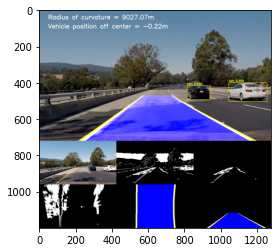

In [18]:
image_path = "test_images/test4.jpg"
out = pipeline(plt.imread(image_path), True)
plt.imshow(out)
plt.show()

## Genere

In [20]:
PYTHONFILE = False

input_video = "test_videos/challenge_video.mp4"
if PYTHONFILE and len(sys.argv) > 1:
    input_video = sys.argv[1]

debug = True
if PYTHONFILE and len(sys.argv) > 2 and sys.argv[2] == "debug":
    debug = True

output_video = "output_videos/" + input_video.split("/")[-1]

start_t = time.time()

clip = VideoFileClip(input_video)
%time clip.fl_image(lambda image: pipeline(image, debug)).write_videofile(output_video, audio=False)

print("Finished at {}".format((time.time() - start_t)/60))

Moviepy - Building video output_videos/challenge_video.mp4.
Moviepy - Writing video output_videos/challenge_video.mp4



Moviepy - Done !
Moviepy - video ready output_videos/challenge_video.mp4
CPU times: user 31min 56s, sys: 1min 2s, total: 32min 59s
Wall time: 5min 28s
Finished at 5.47504358291626
